This is the first article in a series about at least one way to encode many-body quantum mechanics in python (and eventually Haskell too maybe). Why even do this? I think that understanding in principle how to encode the problem conceretely into a computer let's you have a deeper understanding of what the hell is going on. We're not winning any awards for speed or efficiency here. Intentionally. A low level formulation of all this in C using GPU acceleration or something would be significantly less understandble.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

So to start, let's take a few moments to review single body quantum mechanics. It is not trivial, but I feel I should blast by it to get to the actual. Actual electrons in a material are influenced by the coulomb potentials of the nuclei of atoms and by electron-electron coulomb repulsion. 

It is customary in solid state physics for the purposes of clarification to build simplified models of materials. One simplification is to say that electrons can exist on a lattice of sites with onsite energy $\epsilon$ and tunneling energy $t$. This lattice ultimately corresponds back to the crystal lattice of actual atoms and these mystery parameters can be related back closer (but not entirely. There really are huge gaps of deduction in our understanding of the chain of physics from the very small to the large) to first principles by considering the matrix elements of orbital wavefunctions of the atoms. Parametrizing the simplified model let's us cut a Gordian knot that connects us to first principles. For more info check out https://en.wikipedia.org/wiki/Tight_binding.

For simplicity, let's consider a periodic 1-d ring of sites. This is convenient programmatically and mathematically. We can then extend this to greater and greater realism or try to realize such 1-d models in reality using nanowires or other somewhat exotic things.

A wavefunction $\psi$ with the particle sitting on the 0th site can be written like so

[ 1.  0.  0.  0.  0.  0.]


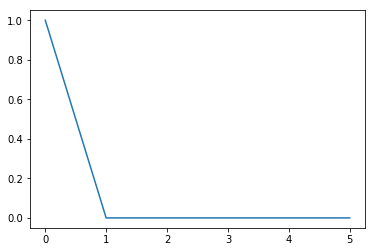

In [8]:
NSites = 6
psi = np.zeros(NSites)
psi[0] = 1
print(psi)
plt.plot(psi)

A simple Hamiltonian. The Hamiltonian has the interpetation of giving the possible energies of the particle, but it is also useful as a way of thinking about which states connect to which in time propagation. The tunneling element connects nearest neighbor sites.
The periodic nature of the Hamiltonian makes it useful to use the circulant matrix construction function from scipy.

In [12]:
from scipy.linalg import circulant

eps = 1.0
t = 0.5

firstcol = np.zeros(NSites)
firstcol[0] = eps
firstcol[1] = t
firstcol[-1] = t

oneH = circulant(firstcol) #Takes first column and repeats it shifted
print(oneH)

[[ 1.   0.5  0.   0.   0.   0.5]
 [ 0.5  1.   0.5  0.   0.   0. ]
 [ 0.   0.5  1.   0.5  0.   0. ]
 [ 0.   0.   0.5  1.   0.5  0. ]
 [ 0.   0.   0.   0.5  1.   0.5]
 [ 0.5  0.   0.   0.   0.5  1. ]]


It is then simple to ask for the energy (eigenvalues) levels of the matrix, or apply it to a wavefunction (which may be part of a single time step for example).

[ 1.-0.1j   0.-0.05j  0.+0.j    0.+0.j    0.+0.j    0.-0.05j]


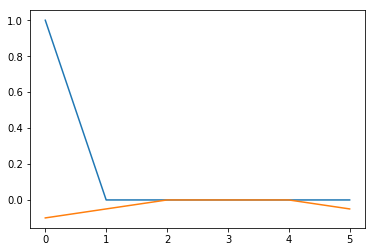

In [20]:
dt = 0.1 # a discretized time step dt.
I = np.eye(NSites)
psi1 = (I - 1.j * dt * oneH) @ psi
print(psi1)
plt.plot(np.real(psi1))
plt.plot(np.imag(psi1))

A first approach to many-body quantum mechanics is the occupation number representation. The states are labelled by a binary string, with 1s correspondng to filled states and 0s to empty states. Since you will need 1 bit per site, the total size of the vector space is $2^{\# Sites}$. To label the states we'll need a couple of bit twiddling tricks.
The common idiom for getting a bit string with the nth bit set is to bit shift a 1 over by n.

In [1]:
bin(1 << 3)

'0b1000'

In [3]:
n = 1 << 3 | 1 << 4

One way to count the number of bits set to one (the total occupation number of the lattice) is to use the following code.

In [4]:
bin(n).count("1")

2

In [5]:
bin(n)

'0b11000'

In [6]:
import gmpy2

In [7]:
gmpy2.popcount(n)

2

Since 0 corresponds to the bit string 0b000000, this is the completely empty state, which we may call the vacuum. We need to set the amplitude of this index to 1.0 so that it accounts for the total quantum amplitude of being empty.

In [8]:
NSites = 6
NStates = 2 ** NSites

def vac(NStates):
    state = np.zeros(NStates)
    state[0] = 1.0
    return state

In [9]:
popcount = np.vectorize(gmpy2.popcount)

We will want to count the number of particles in an occupation binary string. This corresponds to counting the number of 1s in the binary number. The Wikipedia article for Hamming Weight (a name for this operation) has this code for a 64-bit unsigned integer. We'll need to be careful to cast as uint64 or we'll get awful bugs later unfortunately.

In [10]:
#from wikipedia article on hamming weight
# works for 64 bits numbers

m1  = 0x5555555555555555; #binary: 0101...
m2  = 0x3333333333333333; #binary: 00110011..
m4  = 0x0f0f0f0f0f0f0f0f; #binary:  4 zeros,  4 ones ...
m8  = 0x00ff00ff00ff00ff; #binary:  8 zeros,  8 ones ...
m16 = 0x0000ffff0000ffff; #binary: 16 zeros, 16 ones ...
m32 = 0x00000000ffffffff; #binary: 32 zeros, 32 one
hff = 0xffffffffffffffff; #binary: all ones
h01 = 0x0101010101010101;
def popcount64c(x):
    x -= (x >> 1) & m1;             #put count of each 2 bits into those 2 bits
    x = (x & m2) + ((x >> 2) & m2); #put count of each 4 bits into those 4 bits 
    x = (x + (x >> 4)) & m4;        #put count of each 8 bits into those 8 bits 
    return (x * h01) >> 56;  #returns left 8 bits of x + (x<<8) + (x<<16) + (x<<24) + ... 


Now we get to the meat. How do we implement dermionic creation and annihilation operators commonly denoted $a_j^\dagger$ and $a_j$. The operators when applied to a state fill (create a particle) an empty spot at site $j$, or empty it (annihilate the particle).
There is some truly funky business with fermions that we have to anticommute these operators. This is part of the mathematical origin of the Pauli Exclusion principle and has some relation to determinants, which we will see an aspect of later. Don't get me wrong. These minus signs are weird.
To account for them, we pick a canonical ordering or the creation operators, in our case in descending order, for example $a_6^\dagger a_3^\dagger a_0^\dagger |0>$. We only need anti-commute sufficiently to get an operator into it's canonical position in the expression representing the state for example $a_3^\dagger a_6^\dagger a_5^\dagger a_4^\dagger a_0^\dagger |0> = - a_6^\dagger a_5^\dagger a_4^\dagger a_3^\dagger a_0^\dagger |0> $. 
It's complicated and it took me a couple tries to get the binary version of this right.

In [11]:

def reshapeSite(site, state):
    #returns state[leftstatechanges(msb), occupy/unoccupied, rightstatechanges(lsb)]
    return state.reshape((-1, 2,2**site))

def antiCommuteFactor(site, state):
    #applies a -1 for every occupied state to the left (most sig. bits).
    # canonical ordering is to have adag0 closest to the ket
    indices = np.arange(state.size, dtype=np.uint64)
    rightBinary = indices >> site + 1 # shift out all the bits to the right
    isOdd = popcount64c(rightBinary) & 0x1
    return np.where(isOdd, -1, 1) * state
    

def adag(site, state, copy=True):
    if copy:
        state = np.copy(state)
    state = reshapeSite(site,state)
    state[:,1,:] = state[:,0,:] 
    state[:,0,:] = 0
    state = state.flatten()
    return antiCommuteFactor(site,state)


def agad(site, state, copy=True):
    if copy:
        state = np.copy(state)
    state = reshapeSite(site,state)
    state[:,0,:] = state[:,1,:] #turns 1 into a zero
    state[:,1,:] = 0 #nothing comes into the occupied state
    state = state.flatten()
    return antiCommuteFactor(site,state)

def Num(site, state, copy=True):
    if copy:
        state = np.copy(state)
    state = reshapeSite(site,state)
    state[:,0,:] = 0 #zero out if unoccupied
    return state.flatten()

def prettyPrint(state,nsites):
    #avoids printing nearly zero, and puts in ket notation
    returnstr = ""
    for index,amp in enumerate(state):
        if abs(amp) > 0.001:
            returnstr += str(amp) + " * |" + bin(index)[2:].zfill(nsites) + "> + "
    return returnstr + "0"

Here we can see that alternate orderings of applying the operators give opposite signs out front.

In [12]:
state1 = adag(1,adag(0, vac(NStates)))
state2 = adag(0,adag(1, vac(NStates)))
print(prettyPrint(state1, NSites))
print(prettyPrint(state2, NSites))
state1 = adag(3,adag(0, vac(NStates)))
state2 = adag(0,adag(1, vac(NStates)))
print(prettyPrint(state1, NSites))
print(prettyPrint(state1 + state2, NSites))


1.0 * |000011> + 0
-1.0 * |000011> + 0
1.0 * |001001> + 0
-1.0 * |000011> + 1.0 * |001001> + 0


In [13]:
Num(0,np.ones(NStates))

array([ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,
        0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,
        0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.])

In [14]:
Num(1,np.ones(NStates))

array([ 0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
        0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,
        0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.])

In [15]:
np.arange(16).reshape((2,-1))

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15]])

In [16]:
popcount64c(np.array( [0b0000111111111 >> 2] ,dtype=np.uint64)) & 0x1

array([1], dtype=uint64)

Now using these operators we could implement the application of a Hamiltonian fairly easily.
But it may be of interest to upconvert single particle hamiltonians to 

In [95]:
def singleSiteH(i, state):
    eps = 1.0
    t = 0.5
    left = (i+1) % NSites
    return eps * Num(i,state) + \
                t * adag(left, agad(i,state)) + \
                t * adag(i, agad(left,state))
    

def H0(state):
    return sum([singleSiteH(i,state) for i in range(NSites)])
        
        

In [18]:
state = adag(2,vac(NStates))
prettyPrint(H0(H0(state)), NSites)

'0.25 * |000001> + 1.0 * |000010> + 1.5 * |000100> + 1.0 * |001000> + 0.25 * |010000> + 0'

In [40]:
'''
def allNbits(N, length):
    if N == 0:
        yield 0x0
        # if N == Length return 2**length
    else:
        for part in range(N - 1): #partition remaining N-1 bits into a part and N-part-1 
            for alength in range(N, length - N): #needs to be at least size N
                blength = length - 1 - alength # we removed 1 bit and 
                for a in allNbits(part , i):
                    for b in allNbits(N-part-1, length - i - 1):
                        yield  (b << i+1) | (0x1 << i) | a 
'''

from itertools import cycle, islice
def roundrobin(*iterables):
    "roundrobin('ABC', 'D', 'EF') --> A D E B F C"
    # Recipe credited to George Sakkis
    pending = len(iterables)
    nexts = cycle(iter(it).__next__ for it in iterables)
    while pending:
        try:
            for next in nexts:
                yield next()
        except StopIteration:
            pending -= 1
            nexts = cycle(islice(nexts, pending))
            

def allNBits(N,length):
    if N == 0:
        yield 0x0
    elif length == N:
        yield 2**N-1
    else:
        gen1 = allNBits(N, length-1)
        gen1 = map(lambda x: x << 1, gen1)
        gen2 = allNBits(N-1, length-1)
        gen2 = map(lambda x: (x << 1) | 0x1, gen2)
        gen3 =  roundrobin(gen1,gen2)
        for x in gen3:
            yield x

In [44]:
def allNBits(N,length):
    if N == 0:
        yield 0x0
    elif length == N:
        yield 2**N-1
    else:
        for x in allNBits(N, length-1):
            yield x << 1
        for x in allNBits(N-1, length-1):
            yield (x << 1) | 0x1

In [47]:
list(map(bin,allNBits(1, 6)))

['0b100000', '0b10000', '0b1000', '0b100', '0b10', '0b1']

In [29]:
def extractSingleParticleState(state):
    return list(map(lambda i: reshapeSite(i,state)[0,1,0], range(NSites)) )

def extractNParticleState(N, state):
    return state[np.array(list(allNBits(N,NSites)), dtype=np.uint64)]
    


In [22]:
extractSingleParticleState(H0(H0(state)))

[0.25, 1.0, 1.5, 1.0, 0.25, 0.0]

In [30]:
extractNParticleState(1,H0(H0(state)))
# it's reversed from previous.

array([ 0.  ,  0.25,  1.  ,  1.5 ,  1.  ,  0.25])

In [ ]:
def matrixForm(operator):
    pass
    #construct matrix column by column by feeding all basis elements
    

In [ ]:
def basisDFT(state): #This is hard
    pass

In [ ]:
from functools import partial

In [ ]:
adag0 = partial(adag,0)

In [ ]:
adag0(vac(NStates))

In [ ]:
#Only works for one argument
#at this point, it is so tempting to make operators into a class so that we can overload mutiplication
def compose(f,g):
    return lambda x: f(g(x))

In [ ]:
adag0Squared = compose(adag0, adag0)

In [ ]:
adag0Squared(vac(NStates))

In [ ]:
def applySingleParticleOperator(op, state):

In [ ]:
bin(2**3-1)

In [76]:
def binaryToPositionList(occupation):
    pos = []
    for site in range(NSites):
        if (occupation >> site) & 0x1:
            pos.append(site)
            
    return pos

def binarylist(occupation):
    return map(int, bin(occupation)[2:].zfill(NSites))


In [63]:
list(binarylist(0b11))

[0, 0, 0, 0, 1, 1]

In [85]:
def V(poslist):
    U = 0
    for i, pos1 in enumerate(poslist):
        for j in range(i):
            U += 1.0 / abs(pos1 - poslist[j])
    return U

In [66]:
# in the occupation reprsentation, potential enrgy is a diagonal operator that can be applied elementwise
def applyV(state):
     return np.array([V(binaryToPositionList(occ)) for occ in range(NStates)]) * state

In [91]:
state = adag(4, adag(0,vac(NStates))) + adag(3, adag(0,vac(NStates)))
prettyPrint(applyV(state), NSites)


'0.333333333333 * |001001> + 0.25 * |010001> + 0'

In [88]:
V([0,2])

0.5

In [98]:
def H(state):
    return H0(state) + applyV(state)


In [99]:
prettyPrint(H(state), NSites)

'0.5 * |000101> + 2.83333333333 * |001001> + 0.5 * |001010> + 2.75 * |010001> + 0.5 * |010010> + 0.5 * |100001> + -0.5 * |101000> + -0.5 * |110000> + 0'

There we go. That's a watershed moment!

Now, we've only given ourselves the power to apply linear operators. True dense representation of the matrices would allow us to ask for inverse and eigenvalues and things.
But we can approach perturbation theory.